In [1]:
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold
import math
from collections import OrderedDict

from PIL import Image
import albumentations
from pydub import AudioSegment

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pretrainedmodels

from joblib import Parallel, delayed
from wtfml.utils import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

from tqdm.autonotebook import tqdm


In [2]:
train = pd.read_csv("/fred/oz138/test/data/train.csv")
test = pd.read_csv("/fred/oz138/test/data/test.csv")
submission = pd.read_csv("/fred/oz138/test/data/sample_submission.csv")
train.head

<bound method NDFrame.head of        rating playback_used ebird_code    channels        date          pitch  \
0         3.5            no     aldfly    1 (mono)  2013-05-25  Not specified   
1         4.0            no     aldfly  2 (stereo)  2013-05-27           both   
2         4.0            no     aldfly  2 (stereo)  2013-05-27           both   
3         3.5            no     aldfly  2 (stereo)  2013-05-27           both   
4         4.0            no     aldfly  2 (stereo)  2013-05-27           both   
...       ...           ...        ...         ...         ...            ...   
21370     4.5            no     yetvir    1 (mono)  2019-05-15           both   
21371     3.5            no     yetvir    1 (mono)  2017-05-14  Not specified   
21372     5.0            no     yetvir    1 (mono)  2017-06-10  Not specified   
21373     3.5            no     yetvir  2 (stereo)  2009-05-06          level   
21374     3.5            no     yetvir  2 (stereo)  2010-06-09          level  

In [3]:
print("Number of Unique birds : ", train.ebird_code.nunique())

Number of Unique birds :  264


In [4]:
# label encoding 
train["ebird_label"] = LabelEncoder().fit_transform(train['ebird_code'])

In [5]:
train.head

<bound method NDFrame.head of        rating playback_used ebird_code    channels        date          pitch  \
0         3.5            no     aldfly    1 (mono)  2013-05-25  Not specified   
1         4.0            no     aldfly  2 (stereo)  2013-05-27           both   
2         4.0            no     aldfly  2 (stereo)  2013-05-27           both   
3         3.5            no     aldfly  2 (stereo)  2013-05-27           both   
4         4.0            no     aldfly  2 (stereo)  2013-05-27           both   
...       ...           ...        ...         ...         ...            ...   
21370     4.5            no     yetvir    1 (mono)  2019-05-15           both   
21371     3.5            no     yetvir    1 (mono)  2017-05-14  Not specified   
21372     5.0            no     yetvir    1 (mono)  2017-06-10  Not specified   
21373     3.5            no     yetvir  2 (stereo)  2009-05-06          level   
21374     3.5            no     yetvir  2 (stereo)  2010-06-09          level  

In [6]:
# create cross validation with 5 folds
FOLDS = 5

train.loc[:, "kfold"] = -1

train= train.sample(frac=1).reset_index(drop=True)

X = train.resampled_filename.values
y = train.ebird_code.values

kfold = StratifiedKFold(n_splits=5)

for fold, (t_idx, v_idx) in enumerate(kfold.split(X, y)):
    train.loc[v_idx, "kfold"] = fold

print(train.kfold.value_counts())

4    4275
3    4275
2    4275
1    4275
0    4275
Name: kfold, dtype: int64


In [7]:
# arguments
class args:
    
    ROOT_PATH = "/fred/oz138/test/data/train_audio"
    MODEL_PATH = "/fred/oz138/test/model"
    
    num_classes = 264
    max_duration= 5 # seconds
    
    sample_rate = 32000
    
    img_height = 128
    img_width = 313
    
    batch_size = 16
    num_workers = 4
    epochs = 20
    
    lr = 0.0009
    wd = 1e-5
    momentum = 0.9
    eps = 1e-8
    betas = (0.9, 0.999)
    
    melspectrogram_parameters = {
        "n_mels": 128,
        "fmin": 20,
        "fmax": 16000
    }
    

In [8]:
# load audio files
def load_audio(path):
    try:
        sound = AudioSegment.from_mp3(path)
        sound = sound.set_frame_rate(args.sample_rate)
        sound_array = np.array(sound.get_array_of_samples(), dtype=np.float32)
    except:
        sound_array = np.zeros(args.sample_rate * args.max_duration, dtype=np.float32)
        
    return sound_array, args.sample_rate

In [9]:
# audio albumentations
from albumentations.core.transforms_interface import DualTransform, BasicTransform

class AudioTransform(BasicTransform):
    """Transform for Audio task"""

    @property
    def targets(self):
        return {"data": self.apply}
    
    def update_params(self, params, **kwargs):
        if hasattr(self, "interpolation"):
            params["interpolation"] = self.interpolation
        if hasattr(self, "fill_value"):
            params["fill_value"] = self.fill_value
        return params

class NoiseInjection(AudioTransform):
    """It simply add some random value into data by using numpy"""
    def __init__(self, noise_levels=(0, 0.5), always_apply=False, p=0.5):
        super(NoiseInjection, self).__init__(always_apply, p)

        self.noise_levels = noise_levels
    
    def apply(self, data, **params):
        sound, sr = data
        noise_level = np.random.uniform(*self.noise_levels)
        noise = np.random.randn(len(sound))
        augmented_sound = sound + noise_level * noise
        # Cast back to same data type
        augmented_sound = augmented_sound.astype(type(sound[0]))

        return augmented_sound, sr

class ShiftingTime(AudioTransform):
    """Shifting time axis"""
    def __init__(self, always_apply=False, p=0.5):
        super(ShiftingTime, self).__init__(always_apply, p)
    
    def apply(self, data, **params):
        sound, sr = data

        shift_max = np.random.randint(1,len(sound))
        shift = np.random.randint(int(sr * shift_max))
        direction = np.random.randint(0,2)
        if direction == 1:
            shift = -shift

        augmented_sound = np.roll(sound, shift)
        # Set to silence for heading/ tailing
        if shift > 0:
            augmented_sound[:shift] = 0
        else:
            augmented_sound[shift:] = 0

        return augmented_sound, sr

class PitchShift(AudioTransform):
    
    def __init__(self, always_apply=False, p=0.5):
        super(PitchShift, self).__init__(always_apply, p)
    
    def apply(self, data, **params):
        sound, sr = data

        n_steps = np.random.randint(-10, 10)
        augmented_sound = librosa.effects.pitch_shift(sound, sr, n_steps)

        return augmented_sound, sr

class TimeStretch(AudioTransform):
    
    def __init__(self, always_apply=False, p=0.5):
        super(TimeStretch, self).__init__(always_apply, p)
    
    def apply(self, data, **params):
        sound, sr = data

        rate = np.random.uniform(0, 2)
        augmented_sound = librosa.effects.time_stretch(sound, rate)

        return augmented_sound, sr

class RandomAudio(AudioTransform):
    
    def __init__(self,  seconds=5, always_apply=False, p=0.5):
        super(RandomAudio, self).__init__(always_apply, p)

        self.seconds = seconds
    
    def apply(self, data, **params):
        sound, sr = data

        shift = np.random.randint(len(sound))
        trim_sound = np.roll(sound, shift)

        min_samples = int(sr * self.seconds)

        if len(trim_sound) < min_samples:
            padding = min_samples - len(trim_sound)
            offset = padding // 2
            trim_sound = np.pad(trim_sound, (offset, padding - offset), "constant")
        else:
            trim_sound = trim_sound[:min_samples]

        return trim_sound, sr

class MelSpectrogram(AudioTransform):

    def __init__(self, parameters, always_apply=False, p=0.5):
        super(MelSpectrogram, self).__init__(always_apply, p)

        self.parameters = parameters
    
    def apply(self, data, **params):
        sound, sr = data

        melspec = librosa.feature.melspectrogram(sound, sr=sr, **self.parameters)
        melspec = librosa.power_to_db(melspec)
        melspec = melspec.astype(np.float32)

        return melspec, sr

class SpecAugment(AudioTransform):
    
    def __init__(self, num_mask=2, freq_masking=0.15, time_masking=0.20, always_apply=False, p=0.5):
        super(SpecAugment, self).__init__(always_apply, p)

        self.num_mask = num_mask
        self.freq_masking = freq_masking
        self.time_masking = time_masking
    
    def apply(self, data, **params):
        melspec, sr = data

        spec_aug = self.spec_augment(melspec, 
                                     self.num_mask,
                                     self.freq_masking,
                                     self.time_masking,
                                     melspec.min())
        


        return spec_aug, sr
    
    # Source: https://www.kaggle.com/davids1992/specaugment-quick-implementation
    def spec_augment(self, 
                    spec: np.ndarray,
                    num_mask=2,
                    freq_masking=0.15,
                    time_masking=0.20,
                    value=0):
        spec = spec.copy()
        num_mask = random.randint(1, num_mask)
        for i in range(num_mask):
            all_freqs_num, all_frames_num  = spec.shape
            freq_percentage = random.uniform(0.0, freq_masking)

            num_freqs_to_mask = int(freq_percentage * all_freqs_num)
            f0 = np.random.uniform(low=0.0, high=all_freqs_num - num_freqs_to_mask)
            f0 = int(f0)
            spec[f0:f0 + num_freqs_to_mask, :] = value

            time_percentage = random.uniform(0.0, time_masking)

            num_frames_to_mask = int(time_percentage * all_frames_num)
            t0 = np.random.uniform(low=0.0, high=all_frames_num - num_frames_to_mask)
            t0 = int(t0)
            spec[:, t0:t0 + num_frames_to_mask] = value

        return spec

class SpectToImage(AudioTransform):

    def __init__(self, always_apply=False, p=0.5):
        super(SpectToImage, self).__init__(always_apply, p)
    
    def apply(self, data, **params):
        image, sr = data
        delta = librosa.feature.delta(image)
        accelerate = librosa.feature.delta(image, order=2)
        image = np.stack([image, delta, accelerate], axis=0)
        image = image.astype(np.float32) / 100.0

        return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


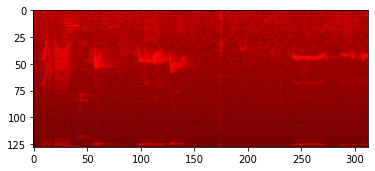

In [10]:
### Example

train_audio_augmentation = albumentations.Compose([
     RandomAudio(seconds=args.max_duration, always_apply=True),
     NoiseInjection(p=0.33),
     MelSpectrogram(parameters=args.melspectrogram_parameters,always_apply=True),
     SpecAugment(p=0.33),
     SpectToImage(always_apply=True)
])

valid_audio_augmentation = albumentations.Compose([
     RandomAudio(seconds=args.max_duration, always_apply=True),
     MelSpectrogram(parameters=args.melspectrogram_parameters,always_apply=True),
     SpectToImage(always_apply=True)
])


path = f"{args.ROOT_PATH}/aldfly/XC135454.mp3"
data = load_audio(path)
image = train_audio_augmentation(data=data)['data']

plt.imshow(image.transpose(1,2,0))
plt.show()


In [11]:
# dataloader
class BirdDataset:
    def __init__(self, df, valid=False):
        
        self.filename = df.filename.values
        self.ebird_label = df.ebird_label.values
        self.ebird_code = df.ebird_code.values
        
        if valid:
            self.aug = valid_audio_augmentation
        else:
            self.aug = train_audio_augmentation
        
    
    def __len__(self):
        return len(self.filename)
    
    def __getitem__(self, item):
        
        filename = self.filename[item]
        ebird_code = self.ebird_code[item]
        ebird_label = self.ebird_label[item]

        data = load_audio(f"{args.ROOT_PATH}/{ebird_code}/{filename}")
        spect = self.aug(data=data)["data"]
        
        target = ebird_label
        
        return {
            "spect" : torch.tensor(spect, dtype=torch.float), 
            "target" : torch.tensor(target, dtype=torch.long)
        }
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 128, 313]) tensor(94)


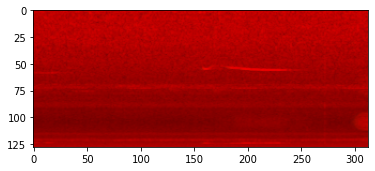

In [12]:
# Example 
dataset = BirdDataset(train)
d = dataset.__getitem__(100)

print(d["spect"].shape, d["target"])

plt.imshow(d["spect"].permute(1,2,0))
plt.show()

In [13]:
# resnet18
class ResNet18(nn.Module):
    def __init__(self, pretrained):
        super(ResNet18, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__["resnet18"](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__["resnet18"](pretrained=None)
        
        self.l0 = nn.Linear(512, args.num_classes)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        x = self.l0(x)
        
        return x


In [14]:
# utility functions
def to_list(tensor):
    return tensor.detach().cpu().tolist()

def reduce_fn(vals):
    return sum(vals) / len(vals)

class AverageMeter(object):
    """Computes and stores the average and current values"""
    def __init__(self):
        self.reset()
    
    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def get_position_accuracy(logits, labels):
    predictions = np.argmax(F.softmax(logits, dim=1).cpu().data.numpy(), axis=1)
    labels = labels.cpu().data.numpy()
    total_num = 0
    sum_correct = 0
    for i in range(len(labels)):
        if labels[i] >= 0:
            total_num += 1
            if predictions[i] == labels[i]:
                sum_correct += 1
    if total_num == 0:
        total_num = 1e-7
    return np.float32(sum_correct) / total_num, total_num

In [15]:
# loss function
def loss_fn(preds, labels):
    loss = nn.CrossEntropyLoss(ignore_index=-1)(preds, labels)
    return loss

In [16]:
# train and validation functions
def train_fn(train_loader, model, optimizer, device, epoch):
    total_loss = AverageMeter()
    accuracies = AverageMeter()
    
    model.train()

    t = tqdm(train_loader)
    for step, d in enumerate(t):
        
        spect = d["spect"].to(device)
        targets = d["target"].to(device)
        
        outputs = model(spect)

        loss = loss_fn(outputs, targets)

        optimizer.zero_grad()
        
        loss.backward()
        #xm.optimizer_step(optimizer, barrier=True)
        optimizer.step()
        
        acc, n_position = get_position_accuracy(outputs, targets)
        
        total_loss.update(loss.item(), n_position)
        accuracies.update(acc, n_position)
        
        
        t.set_description(f"Train E:{epoch+1} - Loss:{total_loss.avg:0.4f} - Acc:{accuracies.avg:0.4f}")
        
    return total_loss.avg

def valid_fn(valid_loader, model, device, epoch):
    total_loss = AverageMeter()
    accuracies = AverageMeter()
    
    model.eval()

    t = tqdm(valid_loader)
    for step, d in enumerate(t):
        
        with torch.no_grad():
        
            spect = d["spect"].to(device)
            targets = d["target"].to(device)

            outputs = model(spect)

            loss = loss_fn(outputs, targets)

            acc, n_position = get_position_accuracy(outputs, targets)

            total_loss.update(loss.item(), n_position)
            accuracies.update(acc, n_position)
            
            t.set_description(f"Eval E:{epoch+1} - Loss:{total_loss.avg:0.4f} - Acc:{accuracies.avg:0.4f}")

    return total_loss.avg, accuracies.avg

In [17]:
# main function
def run(fold_index):

    MX = ResNet18(pretrained=True)
    
    train_df = train[~train.kfold.isin([fold_index])]
    train_dataset = BirdDataset(df=train_df)


    valid_df = train[train.kfold.isin([fold_index])]
    valid_dataset = BirdDataset(df=valid_df, valid=True)

    device = "cuda"
    model = MX.to(device)
    

    train_loader = DataLoader(
        dataset = train_dataset,
        batch_size = args.batch_size,
        pin_memory = True,
        drop_last = False
    )

    valid_loader = DataLoader(
        dataset = valid_dataset,
        batch_size = args.batch_size,
        pin_memory = True,
        drop_last = False
    )

    optimizer = torch.optim.AdamW(model.parameters(),
                                      lr=args.lr,
                                      betas=args.betas,
                                      eps=args.eps,
                                      weight_decay=args.wd
                                 )

    best_acc = 0

    for epoch in range(args.epochs):
        
        train_loss = train_fn(train_loader, model, optimizer, device, epoch)
        
        valid_loss, valid_acc = valid_fn(valid_loader, model, device, epoch)

        print(f"Fold {fold_index} ** Epoch {epoch+1} **==>** Accuracy = {valid_acc}")

        if valid_acc > best_acc:
            torch.save(model.state_dict(), os.path.join(args.MODEL_PATH, f"fold_{fold_index}.bin"))
            best_acc = valid_acc

In [ ]:
run(0)